# Traffic Sign Detection Solution
Source: Tobias Augspurger for Udacity ND

## Load Data and your Dependencies

Load the German Traffic Sign Dataset into train, valid and test data.

In [2]:
import cv2
import numpy as np
import pandas as pd
import random
import pickle
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import signal
import sys
def signal_handler(signal, frame):
        print('You pressed Ctrl+C!')
        sys.exit(0)

# Show Shape and Dimensions
#### 1. Provide a basic summary of the data set. In the code, the analysis should be done using python, numpy and/or pandas methods rather than hardcoding results manually.

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)
Traffic Sign Image Shape: (32, 32, 3)
Number Traffic Sign Training Images 34799
Number of Validation Images 4410
Number of Classes 43


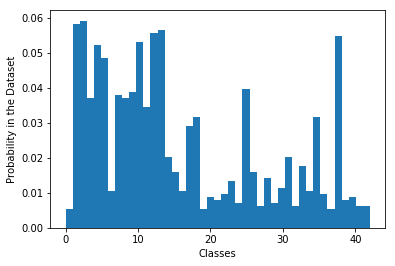

In [3]:
num_c = len(np.unique(y_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Traffic Sign Image Shape: {}".format(X_train[0].shape))
print("Number Traffic Sign Training Images", len(X_train))
print("Number of Validation Images", len(X_validation))
print("Number of Classes",num_c)
# Plot The Probability of the Classes
plt.hist(y_train,bins = num_c, normed = True)
plt.ylabel('Probability in the Dataset')
plt.xlabel('Classes')

**This bar chart is showing, that the distribution of the labels is not equal. This can cause over and underfitting for several classes after training.
A better distribution can be created by generating artifical data for low frequent labels in the dataset.**

## Visualize Data

Show 20 Random Pictures from the Dataset

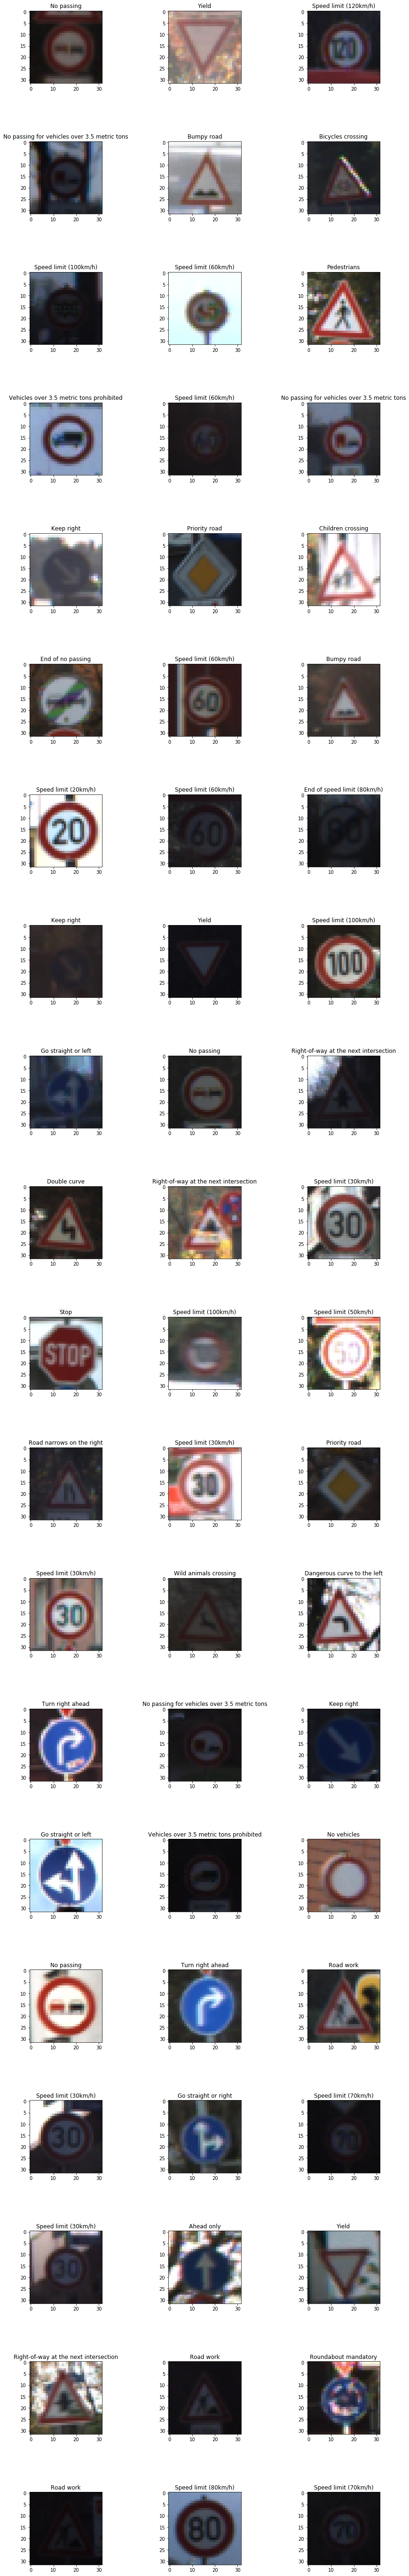

In [4]:
classes = pd.read_csv("signnames.csv")
classes.set_index("ClassId")
plt.figure(figsize=(15, 100))
pic_dis = 60
pic_p_raw = 3

for i in range(0,pic_dis):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.subplot(pic_dis/pic_p_raw ,3,1+i)
    plt.imshow(image, cmap="gray")
    plt.subplots_adjust(hspace=0.8)
    plt.title(classes.at[y_train[index],'SignName'])

# Preprocess Data

#### 1. Describe how you preprocessed the image data. What techniques were chosen and why did you choose these techniques? Consider including images showing the output of each preprocessing technique. Pre-processing refers to techniques such as converting to grayscale, normalization, etc. (OPTIONAL: As described in the "Stand Out Suggestions" part of the rubric, if you generated additional data for training, describe why you decided to generate additional data, how you generated the data, and provide example images of the additional data. Then describe the characteristics of the augmented training set like number of images in the set, number of images for each class, etc.)

**Shuffle the training data and preprocess the features by normalization and reduction of the data to a single channel. Since traffic signs are made for human perception, a converting from RGB to greyscale is done by the intensity distribution of the human eye. The data is normalized from 0 to 1. It makes training much easier, by damping out oscillations in the distribution of activations.**

**I have not done any argumentation of the pictures yet because I want to try to reach the 0.93 validation accuracy just with the neural network. Adjusting the images in brightness, rotation and projection should increase the performance on this limited dataset.**

**The shuffling of the data is done before doing the validation split. This helps us to get no bias into the validation and test, but that can cause variance in the accuracy between training runs.**

In [5]:
def preprocessing_feature(X):
    # Since Traffic Sign have colour Space for humans use that:
    # https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    # Magic Feature Scaling with the a 8 Bit Pixel value
    # https://en.wikipedia.org/wiki/Feature_scaling
    # Rescaling
    X = (X / 255.).astype(np.float32)
    
    #Single Greyscale Channel
    X = X.reshape(X.shape + (1,)) 
    return X

# Shuffle the Trainingsdata
X_test = preprocessing_feature(X_test)
X_train = preprocessing_feature(X_train)
X_train, y_train = shuffle(X_train, y_train)
# Generate a Random Split of the Training and Validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20)

## Setup Your Hyperparamter


#### 3. Describe how you trained your model. The discussion can include the type of optimizer, the batch size, number of epochs and any hyperparameters such as learning rate.
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy. All parameter have been found out by multiple tests. A learning rate of 0.0001 was to low for reaching high levels of accuracy. This could be caused by local minima that can not be left with low learning rate causing only small changes in the weights.

The dropout parameters is the propapility to not drop the weights. Integrated into the fully connected end of the network, they help to generalize the network weights to different kinds of features. The network will not overfit so easy as a result. The propability for a dropout is chosen low since net network is relative small.

In [6]:
EPOCHS = 15
BATCH_SIZE = 128
rate = 0.001
# Since the Model is not to big use smaller dropout
dropc1 = 0.7
dropc2 = 0.8
dropoutfc1 = tf.placeholder(tf.float32)
dropoutfc2 = tf.placeholder(tf.float32)
# Dropout value indicates propapility to keep value
# Dropout is used the reduce the overfitting of the data by switching connections off an on.
# This should increase the generalization

# Define the Architecture of the DNN Model

#### 2. Describe what your final model architecture looks like including model type, layers, layer sizes, connectivity, etc.) Consider including a diagram and/or table describing the final model.
After playing with lots of different types I came back to the original LenNet and exdendet it by other approches. Changing only the existing layers in shape and combination did not improved my results. The concatenate layers helped a lot to increase the accuracy in combination with the existing convolution with max pooling. Dropouts have been integrated at the rare end in the fully connected parts. I can not say, that I followed a straight plan in the mutation of the network over time. A deeper network should better perform was one guidance. A GPU helped a lot while tuning on different network designs and hyperparamter. I could get faster feedback in from of training results.

The basic architecure can be discribed in the following way:
As a base network the LenNet architecture from the Sign Detection Lab was used since the typ of classes are quite the same. Traffic signs and written signs contain visual features for humans like letters and symbols. As Input the network takes 32x32x1 tensors. The depth channel is reduced from RGB to Black and White in the preprocessing. As activation function I use the RELU, since it is used for non linear problems. The concatenate function takes two convolutions and combines them with one single activation function. After every concatenate follows a classical convolution with max pooling layer. With Layer five comes the flattening of the weights into a 2D representation. In this area I integrated the dropout function, that helps the network to forget and generalize the shape of the features.
The network contains 7 Layers in total.


The processing layers are a chain of following filters: 

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 BW image   							| 
| **Layer 1**
    |
| Convolution 5x5     	| 1x1 stride, valid padding, outputs 32x32x64 	|
| RELU					| 												|
| Convolution 3x3     	| 1x1 stride, valid padding, outputs 30x30x6, 
    |
| Concatenate    	    | Fuse with Link A with B
    |
| RELU					|												|
| **Layer 2**
    |
| Convolution 3x3    	| 1x1 stride, valid padding, outputs 28x28x6
    |
| Max pooling	      	| 2x2 stride,  outputs 14x14x64 				|
| Max pooling	      	| 2x2 stride,  outputs 14x14x64 				|
| **Layer 3**
    |
| Convolution 3x3	    | 1x1 stride, valid padding, outputs 10x10x16, Link C      									|
    |
| Convolution 3x3	    | 1x1 stride, valid padding, outputs 10x10x16,        									|
| RELU					|												|
| Concatenate    	    | Fuse Link C and D 
    |
| **Layer 4**
    |
| Convolution 3x3	    | 1x1 stride, valid padding, outputs 1x1x16, 
    |
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 5x5x16				|
| Flatten
    |
| **Layer 5**
    |
| Fully Connected       | 400 in 120 out
    |
| RELU
    |
| Dropout               | Prop = 0.7
    |
| **Layer 6**
    |
| Fully Connected       | 120 in 84 out
    |
| RELU
    |
| Dropout               | Prop = 0.8
    |
| **Layer 7**
    |
| Fully connected		| 84 in 43 out        						
 


In [7]:
def ly0nnet_model(x):
    # 2xConv->Concatenate->Conv->2xPooling->2xConv->Concatente->Pooling->Flatten->FullyConnected_with_dropout

    mu = 0
    sigma = 0.1
    # Kernel Size 5*5
    #Layer 1a: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1a_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    conv1a_b = tf.Variable(tf.zeros(6))
    #Y = x*w+b
    conv1a = tf.nn.conv2d(x,conv1a_w,strides= [1,1,1,1],padding = 'VALID') + conv1a_b
    
    #ReLU Activation.
    conv1a = tf.nn.relu(conv1a)
    
    # Kernel Size 3*3
    #Layer 1b: Convolutional. Input = 32x32x1. Output = 30x30x6.
    conv1b_w = tf.Variable(tf.truncated_normal(shape=(3,3,1,6), mean = mu, stddev = sigma))
    conv1b_b = tf.Variable(tf.zeros(6))
    conv1b = tf.nn.conv2d(x,conv1b_w,strides= [1,1,1,1],padding = 'VALID') + conv1b_b
    
    #Layer 1c: Convolution. conv1b as Input = 30x30x6, Output = 28x28x6
    conv1c_w = tf.Variable(tf.truncated_normal(shape=(3,3,6,6), mean = mu, stddev = sigma))
    conv1c_b = tf.Variable(tf.zeros(6))
    conv1c = tf.nn.conv2d(conv1b, conv1c_w,strides= [1,1,1,1],padding = 'VALID') + conv1c_b
    
    #Concatenate Tensorflow operation
    conv1 = tf.nn.relu(tf.concat([conv1a,conv1c],axis =3))

    #Toggled shape Output Size to 24
    #Layer 2: Convolution. conv1 as Input = 28x28x12, Output = 28x28x6
    conv2_w = tf.Variable(tf.truncated_normal(shape=(1,1,12,24), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(24))
    conv2 = tf.nn.conv2d(conv1, conv2_w,strides= [1,1,1,1],padding = 'VALID') + conv2_b
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')   
    
    #Pooling for conv1a Input = 28x28x6. Output = 14x14x6
    conv1_3 = tf.nn.max_pool(conv1a, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')   
    
    #Layer 3a: Convolutional. Input: 14x14x6. Output = 10x10x16.
    conv3a_w = tf.Variable(tf.truncated_normal(shape = (5,5,24,16),mean= mu, stddev = sigma))
    conv3a_b= tf.Variable(tf.zeros(16))
    conv3a = tf.nn.conv2d(conv2,conv3a_w,strides=[1,1,1,1],padding = 'VALID')+conv3a_b
    
    #Layer 3b: Convolutional. conv1_3 Input: 14x14x6. Output = 10x10x16.
    conv3b_w = tf.Variable(tf.truncated_normal(shape = (5,5,6,16),mean= mu, stddev = sigma))
    conv3b_b= tf.Variable(tf.zeros(16))
    conv3b = tf.nn.conv2d(conv1_3,conv3b_w,strides=[1,1,1,1],padding = 'VALID')+conv3b_b
    
    
    #Concatenate conv3a and conv3b convolutions and use relu on it
    conv3 = tf.nn.relu(tf.concat([conv3a,conv3b],axis =3))
    
    conv4_w = tf.Variable(tf.truncated_normal(shape=(1,1,32,16), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(16))
    conv4 = tf.nn.conv2d(conv3, conv4_w,strides= [1,1,1,1],padding = 'VALID') + conv4_b
    
    #ReLU Activation.
    conv4= tf.nn.relu(conv4)
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv4 = tf.nn.max_pool(conv4,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    #Flatten. Input = 5x5x16. Output = 400.
    conv4 = flatten(conv4)
    
    
    #Layer 5: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal((400,120), mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(conv4,fc1_w)+fc1_b
    
    #ReLU Activation.
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1,dropoutfc1)
    
    #Layer 6: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w)+fc2_b
    
    #ReLU Activation.
    fc2 = tf.nn.relu(fc2)
    
    #Dropout
    fc2 = tf.nn.dropout(fc2,dropoutfc2)
    
    #Layer 5: Fully Connected. Input = 84. Output = 43
    logits_w= tf.Variable(tf.truncated_normal((84,43), mean= mu, stddev= sigma))
    logits_b= tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,logits_w)+logits_b
    
    
    return logits


## Features and Labels
Use one hot encoding for your labeling data.

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
# Number of classes
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Define the Training pileline with a reduction of the mean cross entropy by the Adam optimizer. A softmax function is used to handel the probabilities. 

In [9]:
logits = ly0nnet_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Dynamic adjustment of the learning rate
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropc1 = 1,dropc2 = 1):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2, x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Dont forget to turn on dropout 

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set. 

#### 4. Describe the approach taken for finding a solution and getting the validation set accuracy to be at least 0.93. Include in the discussion the results on the training, validation and test sets and where in the code these were calculated. Your approach may have been an iterative process, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think the architecture is suitable for the current problem.

**LenNet as a fundament architecture was a result of playing arround with muliple DNN I found. I tried lots of capsuled approches to reach a higher level of accuracy but this had no success. The integration of dropout functions over the complete network also failed. After integrating the Concatenate tensorflow operation in combination with more maxpooling I could train the network up to an accuracy of 0.986 with no artifical data. I also started to add an gradient exit to the training itself to stop the network before overfitting but could not finish it.** 

**One of the basic approches was to learn from other networks architectues in combination with a fast feedback of the training. Since the network training progress can be seen after 10 epoches. LenNet with more layers and a dropout function was the right way but I could not reach the 0.93 validation accuracy with the pure dataset. In combination with two convolutions followed by a concatenate as one layer I could reach the 0.93 and higher.**

My final model results were after 15 epochs:
* training set accuracy of 0.993
* validation set accuracy of 0.984
* test set accuracy of 0.924

If an iterative approach was chosen:
* What was the first architecture that was tried and why was it chosen?

**LenNet from the example. I extanded the LenNet by multiple dropout and added more layers in the fully connected part and convolutional part.**  

* What were some problems with the initial architecture?

**The original archictecture had not dropout and convolutional part. By adding more number of layers the network worked better.**  

* How was the architecture adjusted and why was it adjusted? Typical adjustments could include choosing a different model architecture, adding or taking away layers (pooling, dropout, convolution, etc), using an activation function or changing the activation function. One common justification for adjusting an architecture would be due to overfitting or underfitting. A high accuracy on the training set but low accuracy on the validation set indicates over fitting; a low accuracy on both sets indicates under fitting.
* Which parameters were tuned? How were they adjusted and why?

**Dropout and Learningrate were both swiched quite often. I realized, that I could increase the number of EPOCHS to 10 for testing. Configurations that have not trained well until this EPOCH have also not later.**   

* What are some of the important design choices and why were they chosen? For example, why might a convolution layer work well with this problem? How might a dropout layer help with creating a successful model?

**The dropout model was at first not helping, since the values were wrong and i used dropout layers over the complete network. After integrating them only at the end it worked better.**    

If a well known architecture was chosen:
* What architecture?

**LenNet + Dropout + Concatenate **

* Why did you believe it would be relevant to the traffic sign application?

**Since reading signs and reading road signs is quite the same. This DNN should be combined with a DNN that only looks for traffic signs in general in the picture. After cutting this area out the LenNet works well on this limited pixels.**

* How does the final model's accuracy on the training, validation and test set provide evidence that the model is working well?

**A model that show a high accuracy on wild images from the internet should be the perfect benchmark. The performance accuracy can only be measured for real life applications with statistics and much bigger datasets.**

In [ ]:
validation_progress = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2, x: batch_x, y: batch_y})
        
        training_accuracy = evaluate(X_train, y_train, 1, 1)
        validation_accuracy = evaluate(X_validation, y_validation, 1, 1)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_progress.append(validation_accuracy)
        if len(validation_progress) > 1: 
            prog_grad = np.gradient(validation_progress)
            #print("Gradients:")
            #print(prog_grad)
    
    saver.save(sess, './ly0nnet')
    print("Model saved")
    plt.plot(validation_progress)
    plt.tight_layout()
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epochs')

Training...

EPOCH 1 ...
Training Accuracy = 0.519

Validation Accuracy = 0.500

EPOCH 2 ...
Training Accuracy = 0.841

Validation Accuracy = 0.837



In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test,1,1)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

## Load Wild Images

#### 1. Choose five German traffic signs found on the web and provide them in the report. For each image, discuss what quality or qualities might be difficult to classify.
Here are five German traffic signs that I found on the web.
The first will be very hard to classify since the sign itself is small in the picture and you will find lots of features around the image. The secound image has also another sign on the picture. This is hard, since the network can not classify two classes as out. 

#### 2. Discuss the model's predictions on these new traffic signs and compare the results to predicting on the test set. At a minimum, discuss what the predictions were, the accuracy on these new predictions, and compare the accuracy to the accuracy on the test set (OPTIONAL: Discuss the results in more detail as described in the "Stand Out Suggestions" part of the rubric).

| Image			        |     Prediction	        					| 
|:---------------------:|:---------------------------------------------:| 
| Ahead Only     		| Speed Limit 50   									| 
| General Caution    			| Speed Limit										|
| No Entry					| No Entry											|
| Ahead Only	      		| Ahead Only					 				|
| Turn Right Ahead		| Speed Limit 50 km/h
    |
| Priority Road    | Priority Road
    |
    
The overall accuracy is low, since the pictures that I used are difficult in perspective. The datset contains mostly straight view only on the traffic sign in the middle. The first image is large in size but the sign is small relative to the image. The network has not been trained on such data. After resizing the sign is very little and is only contained be some individual pixels. The general caution image contains two signs in combination that also has not been trained. In most training images most of other traffic signs are cut off. The pictures are in general much more realistic than the ones from the dataset. At this point the argumentation of the data could help a lot, since most images from the training dataset have a straight view on the traffic sign. Three of the failed images contain a cloudy or blue background. The general caution sign also looks like modfied in the colorspace. The second "Ahead Only" sign also has some latters on the image but the network is not influence in this case.

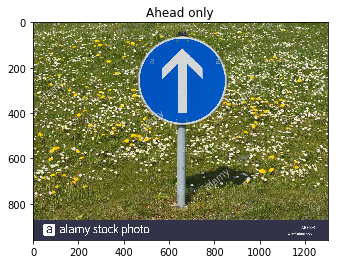

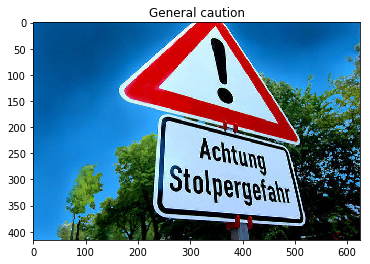

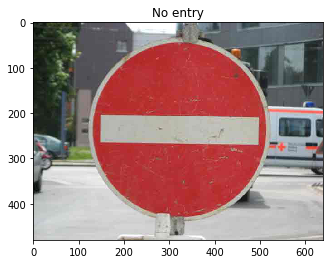

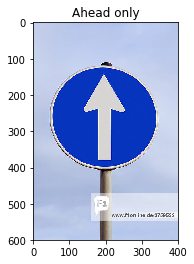

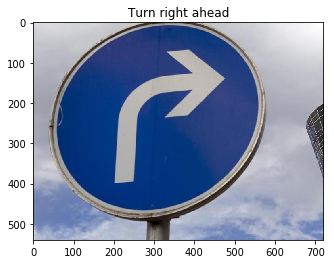

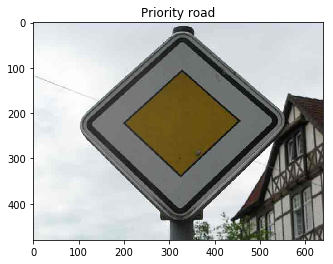

In [12]:
images_w = []
labels_w = []
images_w_org = []
import glob
from PIL import Image
for line in open('random_valid/data','r'):
    fname, label = line.strip().split(' ')
    label = int(label)
    fname = 'random_valid/'+fname
    img = cv2.imread(fname)
    # Convert the Image to BW
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # OpenCV is Saving the RGB in BGR
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(classes.at[label,'SignName'])
    plt.show()
    # Resize
    img_sized = cv2.resize(grey,(32,32))
    # Normalize in [0] to [1]
    img_sized = (img_sized / 255.0)
    # Add the Last Dimension to get (?,32,32,1) for the tf placeholder
    img_sized.shape = img_sized.shape + (1,)
    images_w.append(img_sized)
    labels_w.append(label)
    images_w_org.append(img)
    

# Check the Top5 Softmax probabilities


In [30]:
k = 5
smax_logits = tf.nn.softmax(logits)
top_n = tf.nn.top_k(smax_logits,k=k)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    wild_smax_logits = sess.run(smax_logits, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2,x: images_w})
    top_k = sess.run(top_n, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2,x: images_w})
print(top_k)

TopKV2(values=array([[  9.43634331e-01,   4.41549942e-02,   4.88108164e-03,
          4.78375005e-03,   8.03825445e-04],
       [  9.99999881e-01,   3.70366173e-08,   2.82697457e-08,
          1.19286145e-08,   7.63520092e-09],
       [  9.98320162e-01,   1.67973212e-03,   3.58957237e-08,
          4.67999506e-09,   6.55847487e-10],
       [  9.75061834e-01,   2.48535238e-02,   6.79208752e-05,
          1.27954190e-05,   2.55851501e-06],
       [  8.16910505e-01,   6.34728596e-02,   6.22065663e-02,
          1.93469226e-02,   1.06942328e-02],
       [  9.99993205e-01,   5.96579821e-06,   7.81618326e-07,
          1.81108497e-08,   1.46154804e-08]], dtype=float32), indices=array([[12, 35, 40,  2, 13],
       [38, 34, 18, 14, 12],
       [17, 14, 38, 39,  4],
       [35,  9, 28, 41, 16],
       [ 1, 13,  2, 35, 12],
       [12, 38, 15, 29,  9]], dtype=int32))


#### 3. Describe how certain the model is when predicting on each of the five new images by looking at the softmax probabilities for each prediction. Provide the top 5 softmax probabilities for each image along with the sign type of each probability. (OPTIONAL: as described in the "Stand Out Suggestions" part of the rubric, visualizations can also be provided such as bar charts)

The propability distibutions are clear but often wrong. The reasons for that are discussed above but the level of "accuracy" the network is reporting is very limited. This is a huge problem with DNN networks. They can be very good in accuracy but fail unpredictable. Thats why classical computer vision needs to support DNNs.

True Label ID and Name:
35
Ahead only

Predicted Label:
Ahead only


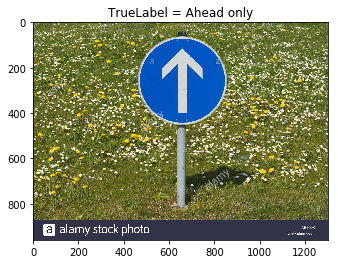

Highest Softmax value:
0.619608



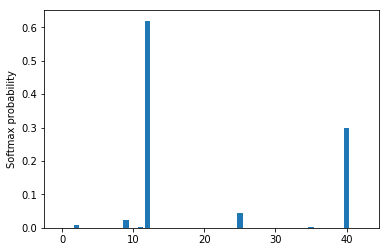


-----------------------------------------------------

True Label ID and Name:
18
General caution

Predicted Label:
Ahead only


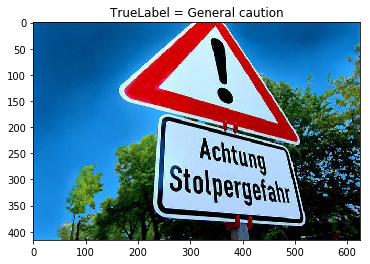

Highest Softmax value:
1.0



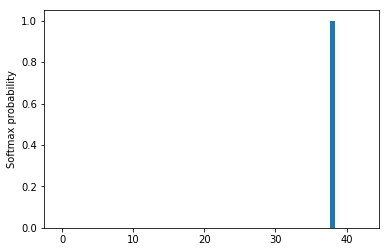


-----------------------------------------------------

True Label ID and Name:
17
No entry

Predicted Label:
Ahead only


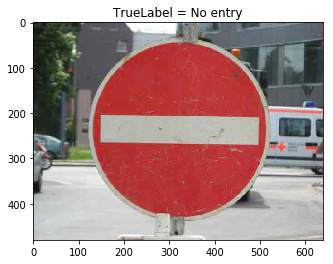

Highest Softmax value:
0.999999



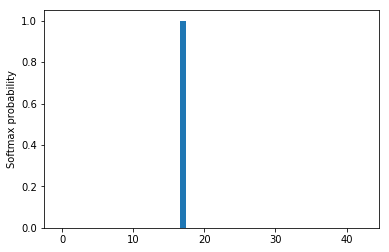


-----------------------------------------------------

True Label ID and Name:
35
Ahead only

Predicted Label:
Ahead only


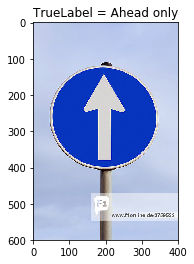

Highest Softmax value:
0.915571



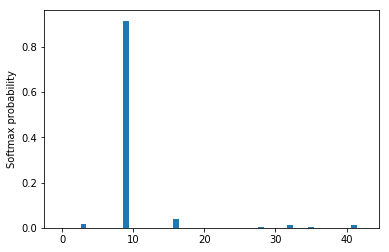


-----------------------------------------------------

True Label ID and Name:
33
Turn right ahead

Predicted Label:
Ahead only


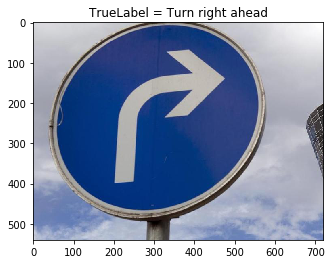

Highest Softmax value:
0.831864



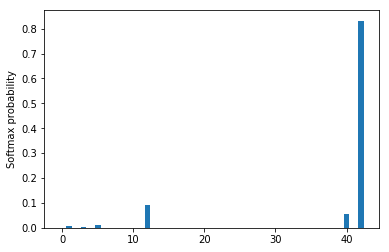


-----------------------------------------------------

True Label ID and Name:
12
Priority road

Predicted Label:
Ahead only


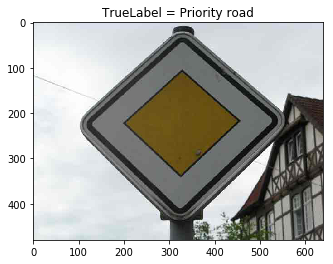

Highest Softmax value:
0.99673



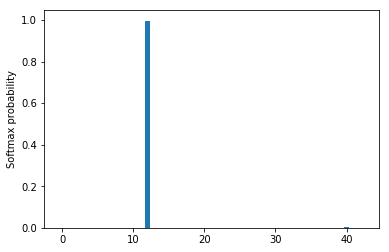


-----------------------------------------------------

[  3.43192252e-09   8.04131487e-05   7.41599454e-03   6.09545328e-04
   1.34511716e-12   2.63056372e-05   1.27964626e-07   3.09748401e-07
   6.06757811e-10   2.44318284e-02   1.47112805e-04   1.35264744e-03
   6.19607687e-01   1.44840726e-06   4.71931935e-06   6.79740353e-09
   1.03884537e-08   5.09611127e-05   7.11822875e-12   4.80879135e-05
   7.22765471e-05   2.17200295e-07   2.76072264e-12   4.21571516e-04
   4.07607033e-08   4.54207174e-02   1.14257954e-08   6.98001336e-13
   7.38478491e-07   9.26334687e-05   1.72648157e-04   2.57261547e-07
   2.66796320e-07   2.26990522e-07   4.37156984e-07   2.51067849e-03
   1.46254865e-06   7.59092702e-12   3.80122373e-07   2.45931463e-15
   2.97406137e-01   1.89607599e-05   1.03086051e-04]


In [37]:
for i in range(len(images_w_org)):
    plt.imshow(cv2.cvtColor(images_w_org[i],cv2.COLOR_BGR2RGB))
    plt.title("TrueLabel = "+classes.at[labels_w[i],'SignName'])
    print("True Label ID and Name:")
    print(labels_w[i])
    print(classes.at[labels_w[i],'SignName'])
    
    print()
    print("Predicted Label:")
    top_i = top_k[1]
    p_id = top_i.item(1)
    print(classes.at[p_id,'SignName'])
    plt.show()
    
    plt.figure()
    plt.ylabel('Softmax probability')
    plt.bar(np.arange(num_c),wild_smax_logits[i])
    print("Highest Softmax value:")
    print(np.max(wild_smax_logits[i]))
    print()
    plt.show()
    print()
    print("-----------------------------------------------------")
    print()

print(wild_smax_logits[0])
print(top_k)